In [1]:
import gym
import numpy as np

### Building way to get from state to bins

In [2]:
def state_to_bin(state, num_bins, min_state, max_state):
    bins = np.arange(min_state, max_state, (max_state - min_state)/(num_bins-1))
    bins = np.round(bins, 4)
    return np.digitize(state, bins)

In [3]:
print(state_to_bin(-1,10,-2,5))

2


In [4]:
min_state, max_state, num_bins = -2, 5, 10
bins = np.arange(min_state, max_state, (max_state - min_state)/(num_bins-1))
print(np.round(bins, 4))

[-2.     -1.2222 -0.4444  0.3333  1.1111  1.8889  2.6667  3.4444  4.2222]


### Define q-learning policy class

In [38]:
class Policy(object):
    def __init__(self, num_bins):
        self.states = []
        self.state_bined = np.zeros((4)).astype(int)
        # Q-Learning parameters
        self.epsilon = 0.1
        self.gamma = 0.9
        self.r_learn = 0.1
        # Bin boundaries
        self.mins = [-0.25, -2 ,-0.25 ,-1]
        self.maxs = [0.25, 2, 0.25, 1]#[0.049854, 0.049982, 0.264013, 3.293350]
        self.num_bins = num_bins
        # Q table:
        self.Q = np.zeros(([self.num_bins]*4)), np.zeros(([self.num_bins]*4))  # all states + action 0,1
        
    def bin_transformation(self, state):
        # Transform state to bins
        state_bined = np.zeros((4)).astype(int)
        for i in range(4):
            state_bined[i] = state_to_bin(state[i],self.num_bins, self.mins[i], self.maxs[i])
        self.state_bined = state_bined
        
    def decide_action(self, x):
        # Chose action based on current state and Q-table
        Q0 = self.Q[0][x[0], x[1], x[2], x[3]] 
        Q1 = self.Q[1][x[0], x[1], x[2], x[3]]
        if (np.random.rand(1)[0] < self.epsilon) or (Q0 == Q1 == 0):
            # Choose random action:
            return np.random.randint(0, 2)
        else:
            return np.argmax((Q0, Q1))
    
    def start_new_run(self, env):
        # Do one full cartpole run
        self.state = env.reset()
        self.bin_transformation(self.state)
        done = False
        counter = 0
        while done == False:
            state, done = self.do_step(self.state_bined, env, counter)
            self.state = state
            self.bin_transformation(self.state)
            #print(self.state, self.state_bined)
            counter += 1
            
        return counter
        
    def do_step(self, old_state, env, counter): 
        """ Chose action, take step, 
        """
        action = self.decide_action(old_state)
        Q_old = self.Q[action][old_state[0], old_state[1], old_state[2], old_state[3]]
        
        # Do actin to get to new state
        new_state, reward, done, _ = env.step(action) 
        # MODIFY REWARD !?!
        if done == True and counter <199:
            reward = -300
        self.bin_transformation(new_state)
        
        # Update Q-table
        x = self.state_bined.copy()
        Q_target = reward + self.gamma * max(self.Q[0][x[0], x[1], x[2], x[3]], self.Q[1][x[0], x[1], x[2], x[3]])
        Q_delta = Q_target - Q_old
        self.Q[action][old_state[0], old_state[1], old_state[2], old_state[3]] += self.r_learn * Q_delta
        return new_state, done

In [36]:
def q_learning(iter, num_bins, env):
    # Run iter cartpole runs and collect run time lengths
    policy = Policy(num_bins=num_bins)
    
    run_lengths = []
    Q_table_fill = []
    for i in range(iter):
        counter = policy.start_new_run(env)
        Q_elements_filled = np.sum(policy.Q[0] != 0) + np.sum(policy.Q[1] != 0)
        Q_table_fill.append(100*Q_elements_filled/(2*policy.num_bins**4))
        run_lengths.append(counter)
        
    return run_lengths, Q_table_fill
        

In [14]:
env = gym.make('CartPole-v0')
run_lengths, Q_table_fill = q_learning(1000, env)

Text(0,0.5,'Q table fill (percentage)')

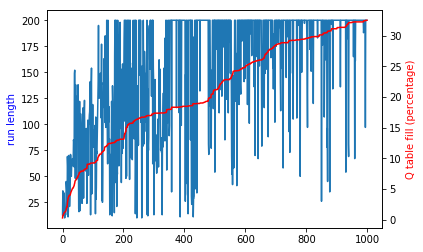

In [18]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(run_lengths)
ax1.set_ylabel('run length', color='b')
ax2 = ax1.twinx()
ax2.plot(Q_table_fill, c='r')
ax2.set_ylabel('Q table fill (percentage)', color='r')

In [21]:
#env = gym.make('CartPole-v0')
run_lengths, Q_table_fill = q_learning(4000, env)

Text(0,0.5,'Q table fill (percentage)')

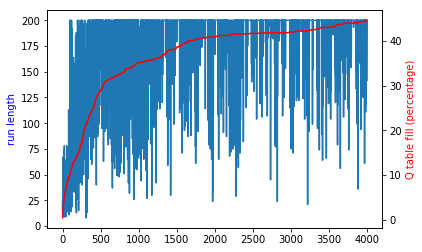

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(run_lengths)
ax1.set_ylabel('run length', color='b')
ax2 = ax1.twinx()
ax2.plot(Q_table_fill, c='r')
ax2.set_ylabel('Q table fill (percentage)', color='r')

### Test variable epsilon

In [32]:
class Policy2(object):
    def __init__(self, num_bins):
        self.states = []
        self.state_bined = np.zeros((4)).astype(int)
        # Q-Learning parameters
        self.epsilon = 1
        self.epsilon_decay = 0.0005
        self.epsilon_final = 0.05
        self.gamma = 0.9
        self.r_learn = 0.1
        # Bin boundaries
        self.mins = [-0.25, -2 ,-0.25 ,-1]
        self.maxs = [0.25, 2, 0.25, 1]#[0.049854, 0.049982, 0.264013, 3.293350]
        self.num_bins = num_bins
        # Q table:
        self.Q = np.zeros(([self.num_bins]*4)), np.zeros(([self.num_bins]*4))  # all states + action 0,1
        
    def bin_transformation(self, state):
        # Transform state to bins
        state_bined = np.zeros((4)).astype(int)
        for i in range(4):
            state_bined[i] = state_to_bin(state[i],self.num_bins, self.mins[i], self.maxs[i])
        self.state_bined = state_bined
        
    def decide_action(self, x):
        # Chose action based on current state and Q-table
        Q0 = self.Q[0][x[0], x[1], x[2], x[3]] 
        Q1 = self.Q[1][x[0], x[1], x[2], x[3]]
        if (np.random.rand(1)[0] < self.epsilon) or (Q0 == Q1 == 0):
            # Choose random action:
            return np.random.randint(0, 2)
        else:
            return np.argmax((Q0, Q1))
    
    def start_new_run(self, env):
        # Do one full cartpole run
        self.state = env.reset()
        self.bin_transformation(self.state)
        done = False
        counter = 0
        while done == False:
            state, done = self.do_step(self.state_bined, env, counter)
            self.state = state
            self.bin_transformation(self.state)
            #print(self.state, self.state_bined)
            counter += 1
            
            # Decaying epsilon
            if self.epsilon > self.epsilon_final:
                self.epsilon = self.epsilon - self.epsilon_decay
            else:
                self.epsilon = self.epsilon_final
            
        return counter
        
    def do_step(self, old_state, env, counter): 
        """ Chose action, take step, 
        """
        action = self.decide_action(old_state)
        Q_old = self.Q[action][old_state[0], old_state[1], old_state[2], old_state[3]]
        
        # Do actin to get to new state
        new_state, reward, done, _ = env.step(action) 
        # MODIFY REWARD !?!
        if done == True and counter <199:
            reward = -300
        self.bin_transformation(new_state)
        
        # Update Q-table
        x = self.state_bined.copy()
        Q_target = reward + self.gamma * max(self.Q[0][x[0], x[1], x[2], x[3]], self.Q[1][x[0], x[1], x[2], x[3]])
        Q_delta = Q_target - Q_old
        self.Q[action][old_state[0], old_state[1], old_state[2], old_state[3]] += self.r_learn * Q_delta
        return new_state, done
    

def q_learning2(iter, num_bins, env):
    # Run iter cartpole runs and collect run time lengths
    policy = Policy2(num_bins = num_bins)
    
    run_lengths = []
    Q_table_fill = []
    for i in range(iter):
        counter = policy.start_new_run(env)
        Q_elements_filled = np.sum(policy.Q[0] != 0) + np.sum(policy.Q[1] != 0)
        Q_table_fill.append(100*Q_elements_filled/(2*policy.num_bins**4))
        run_lengths.append(counter)
        
    return run_lengths, Q_table_fill

In [33]:
env = gym.make('CartPole-v0')
run_lengths, Q_table_fill = q_learning2(2000, env)

Text(0,0.5,'Q table fill (percentage)')

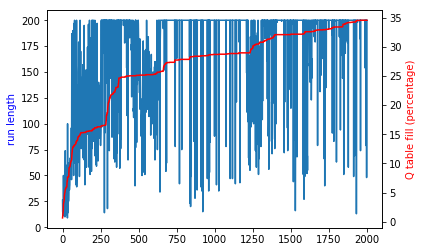

In [34]:
fig, ax1 = plt.subplots()
ax1.plot(run_lengths)
ax1.set_ylabel('run length', color='b')
ax2 = ax1.twinx()
ax2.plot(Q_table_fill, c='r')
ax2.set_ylabel('Q table fill (percentage)', color='r')

Mhh OK, this epsilon variation doesn't seem to add much...

### Try other number of bins 
(4 bins)

In [39]:
env = gym.make('CartPole-v0')
run_lengths, Q_table_fill = q_learning(1000, 4, env)

Text(0,0.5,'Q table fill (percentage)')

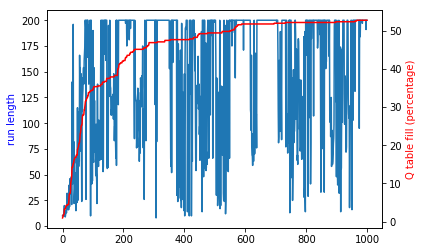

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(run_lengths)
ax1.set_ylabel('run length', color='b')
ax2 = ax1.twinx()
ax2.plot(Q_table_fill, c='r')
ax2.set_ylabel('Q table fill (percentage)', color='r')

### 8 bins (takes longer to explore...)

In [43]:
env = gym.make('CartPole-v0')
run_lengths, Q_table_fill = q_learning(4000, 8, env)

Text(0,0.5,'Q table fill (percentage)')

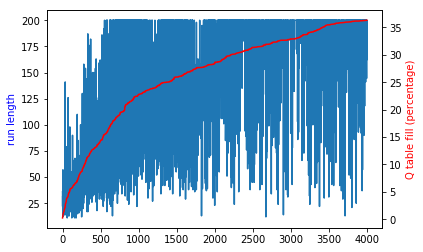

In [45]:
fig, ax1 = plt.subplots()
ax1.plot(run_lengths)
ax1.set_ylabel('run length', color='b')
ax2 = ax1.twinx()
ax2.plot(Q_table_fill, c='r')
ax2.set_ylabel('Q table fill (percentage)', color='r')

In [46]:
np.mean(run_lengths[:-500])

140.81914285714285